**Prepared Dataset and The Other Stuffs**

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
from os import getcwd
%matplotlib inline

In [2]:
#pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import splitfolders

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#input_file = '/content/drive/MyDrive/DATASETS'
#output_file = '/content/drive/MyDrive/DATASETS SPLITTED'

***Split to Train, Test, Val and Preprocessed Dataset***

In [ ]:
#splitfolders.ratio(input_file, output=output_file, seed=123, ratio=(.8, .1, .1), group_prefix=None)

In [18]:
base_dir='/content/drive/MyDrive/DATASETS SPLITTED'
train_dir= os.path.join(base_dir, 'train')
val_dir= os.path.join(base_dir, 'val')
test_dir= os.path.join(base_dir, 'test')

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (300, 300)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 7105 files belonging to 13 classes.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 885 files belonging to 13 classes.


In [21]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 897 files belonging to 13 classes.


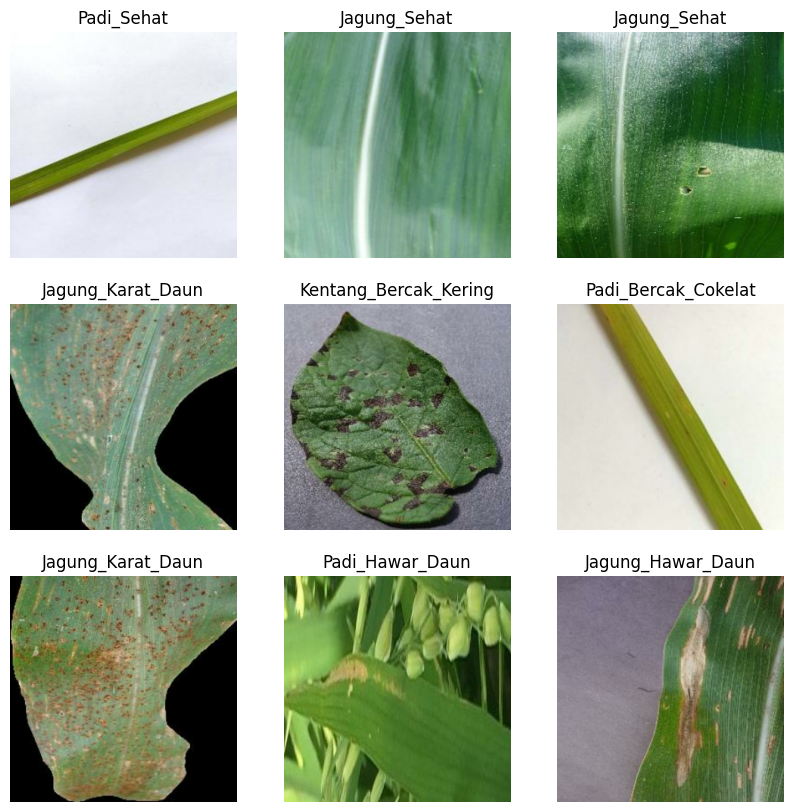

In [22]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [105]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

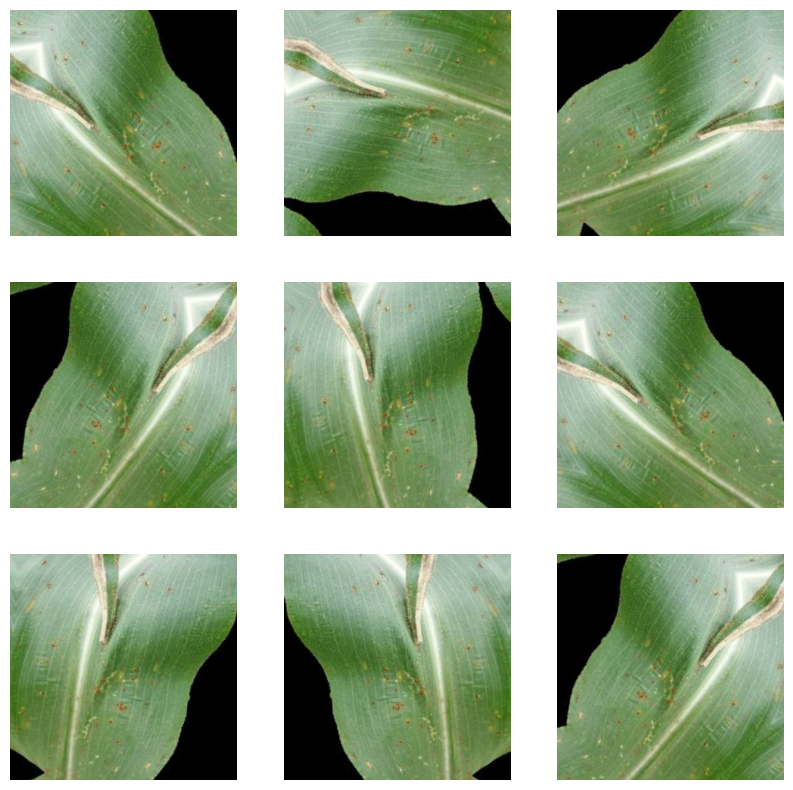

In [25]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Create Transfer Learning

In [26]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [27]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')

In [28]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1536)


In [29]:
base_model.trainable = False

In [30]:
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 300, 300, 3)  0           ['normalization[0][0

In [32]:
#Define Our Model Architectures
convol_layer1 = tf.keras.layers.Conv2D(32, 3, activation="relu")
convol_layer2 = tf.keras.layers.Conv2D(64, 3, activation="relu")
max_pooling_layer = tf.keras.layers.MaxPooling2D()
flatten_layer = tf.keras.layers.Flatten()
dense_layer1 = tf.keras.layers.Dense(128, activation='relu')
dense_layer2 = tf.keras.layers.Dense(64, activation="relu")
prediction_layer = tf.keras.layers.Dense(13, activation='softmax') 

In [33]:
#Combine Transfer Learning and Our Model
inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = convol_layer1(x) 
x = max_pooling_layer(x)
x = convol_layer2(x) 
x = max_pooling_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = flatten_layer(x)
x = dense_layer1(x)
x = dense_layer2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 300, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 efficientnetb3 (Functional)    (None, 10, 10, 1536  10783535    ['sequential_1[0][0]']           
                                )                                                                 
                                                                                              

In [38]:
#Evaluate Our Final Model Architectures
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [39]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds, callbacks=[callback])

Epoch 1/10


Copying files: 6 files [11:49, 118.25s/ files]


223/223 [==============================] - 86s 311ms/step - loss: 1.2091 - accuracy: 0.5710 - val_loss: 0.5824 - val_accuracy: 0.7808
Epoch 2/10
223/223 [==============================] - 74s 325ms/step - loss: 0.6097 - accuracy: 0.7602 - val_loss: 0.4462 - val_accuracy: 0.8339
Epoch 3/10
223/223 [==============================] - 75s 327ms/step - loss: 0.4910 - accuracy: 0.8184 - val_loss: 0.4155 - val_accuracy: 0.8328
Epoch 4/10
223/223 [==============================] - 68s 297ms/step - loss: 0.4414 - accuracy: 0.8374 - val_loss: 0.3630 - val_accuracy: 0.8554
Epoch 5/10
223/223 [==============================] - 71s 311ms/step - loss: 0.3962 - accuracy: 0.8535 - val_loss: 0.3805 - val_accuracy: 0.8588
Epoch 6/10
223/223 [==============================] - 67s 295ms/step - loss: 0.3524 - accuracy: 0.8677 - val_loss: 0.3414 - val_accuracy: 0.8701
Epoch 7/10
223/223 [==============================] - 65s 283ms/step - loss: 0.3346 - accuracy: 0.8799 - val_loss: 0.3519 - val_accuracy: 0.8

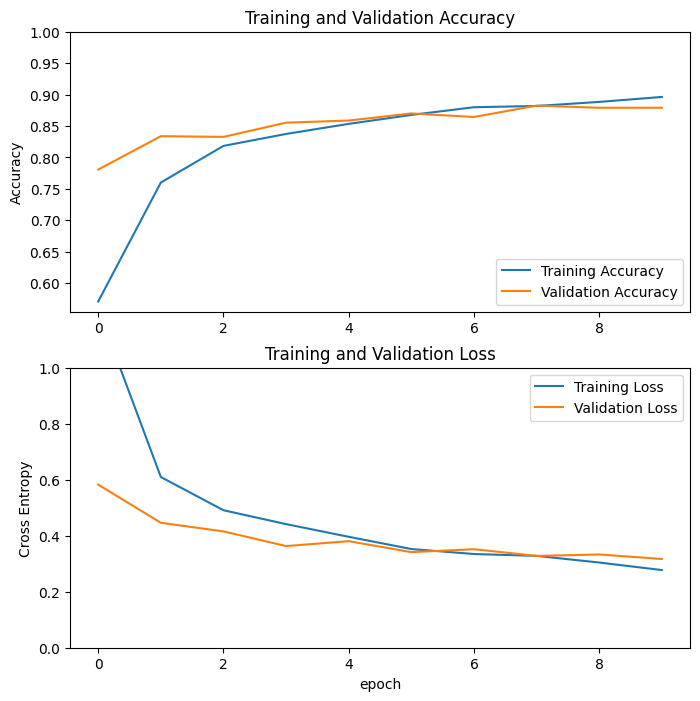

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [83]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

29/29 [==============================] - 8s 216ms/step - loss: 0.3372 - accuracy: 0.8696
Test accuracy : 0.8695651888847351


In [107]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [109]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [110]:
predictions = probability_model.predict(features)

29/29 [==============================] - 8s 189ms/step


In [111]:
predictions[0]

array([0.06794339, 0.06794303, 0.06794295, 0.18468271, 0.06794304,
       0.06794295, 0.06794299, 0.06794304, 0.067943  , 0.06794357,
       0.067943  , 0.06794302, 0.06794335], dtype=float32)

In [112]:
np.argmax(predictions[0])

3

In [113]:
targets[0]

3

Predictions:
 9206
Labels:
 [ 3  3  4  1  9  4 12  9  0  0  3  2  9  7  6  8 10  0  1  1 10  6  4  2
  2  0 12  1 10  9  1 10  5  4  2  4  1  0  2  1  1  5  2  7  8  1  0  2
  2  1 11  1  0  0 10 10  9  9  9  2  3 12  1  1  9  5  2 10  3  0  3  1
  5  9  8 11  0  4  4  1 10  1  2  8  0  0  3  3  2  3  7  1  5  7  7 12
  5  3 10  8  1  1  1  7  4 10  7  0  1 11 11  1 10  3  3 12  6  2  3  7
  2  1  7 12  1  2 11  4  3  6  8  3 12  1  9  5  3  1  0 12  2  1  9 11
  9  6  1  6  3  3  4  2  2 10 11  3  2  4  0  5  8  4  1 12 10  3  2  1
 12  3 10  9  3  3  5  0  1  4  9  3  2  0  0 11 10  3  2  4  3  6  3  6
  1 10  1  3 10  2 12  1 12  1  4 11  0 12  3 10  3  4  7  1  2  0  6 11
 11  1  7  4  2  2  5  1  0  2  2  5  0  2 10  2  4 11  0  5  8  7 11  8
  0  3  5  2  0  1  3  7 10 10 12  6  3  9  6  3  5  3  3  6  1 12 12  2
 10  1  2 11  3  1  9  1  1  7 11 12  7  1 11  9  9 11  9  3 10  9  9  1
  5  1  2  0  7  5  4  4  2  8 11  8  7  4  2  0 10  6  9  1  7  4 12  2
  3 11  1  9  3  0  9  

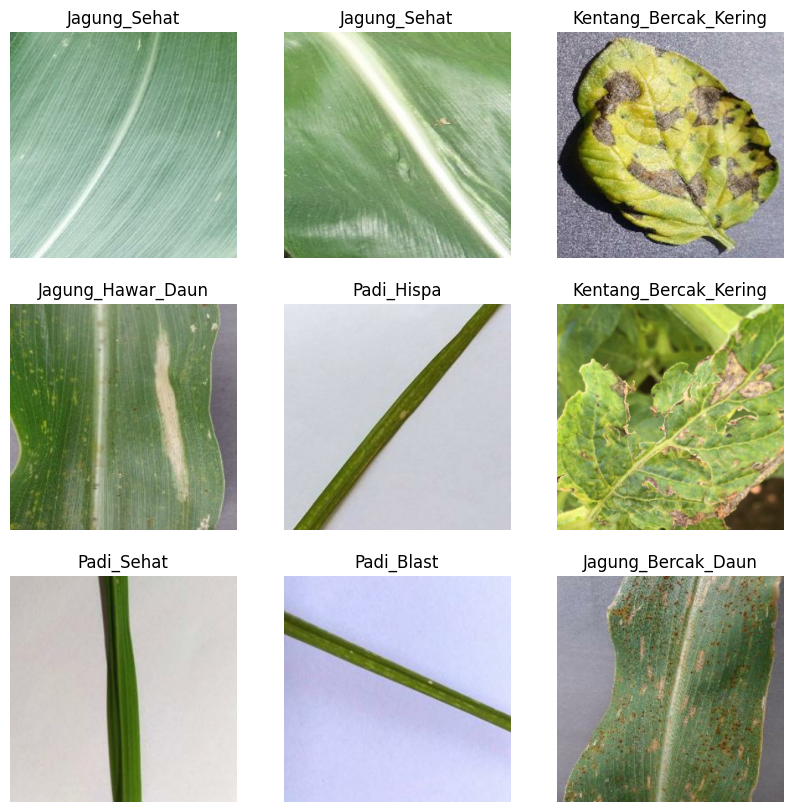

In [130]:
print('Predictions:\n', np.argmax(predictions))
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))
 
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

In [118]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=None)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

ValueError: ignored

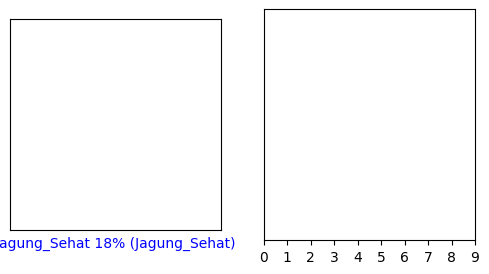

In [119]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], targets, features)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  features)
plt.show()

**Prediksi nya belum ketemu, error terus**

In [81]:
pred=model.predict(test_ds)
#printing the first element from predicted data
print(pred[0])
#printing the index of 
print('Index:',np.argmax(pred[0]))

29/29 [==============================] - 87s 3s/step
[6.3027223e-06 2.8265626e-05 9.5636606e-05 5.3235573e-05 7.6193310e-04
 1.6676760e-04 6.2532513e-04 3.8702423e-05 7.0046738e-02 6.5053944e-03
 2.0416674e-05 1.7541492e-01 7.4623644e-01]
Index: 12


**ANOTHER**